In [3]:
import sys
#Change to own path
sys.path.insert(0, "/home/npatzlaff/Documents/rewiring-effects/")
from funcs.base import *
from tqdm import tqdm
import pickle

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Examing the impact of firing rates on rewiring effects

In [4]:
#Load posterior
with open("/home/npatzlaff/Documents/Inhibition_defines/results/SmallNet_posterior_21-06-24.pkl", "rb") as handle:
    posterior = pickle.load(handle)
#Previously found summary stats returned by calc_stats()
obs = np.array([1.2485e+01, 2.1843e+02, 1.2732e+01, 2.1039e+02, 1.0577e+00, 1.1265e+00,
        1.0945e-01, 1.2310e-01])

In [ ]:
#Getting parameters for given firing rate range
fr_range = np.arange(1, 21, 1) #FRs in Hz

#list of parameters
in_fr_params = []
#for every firing rate
for fr in tqdm(fr_range):
    #copy stats
    temp_obs = obs.copy()
    #inhibitory firing rate is target firing rate
    temp_obs[2] = fr
    #best posterior estimate
    p = posterior.map(x=temp_obs, num_iter=100, 
                                   learning_rate=0.01, num_init_samples=10000, num_to_optimize=1000, 
                                   save_best_every=500, show_progress_bars=True)
    in_fr_params.append(p)

In [ ]:
#Run network and get rewiring results
n_runs = 1

#correlation coefficients for excitatory population
ex_correlation_coeffs = np.zeros((5, 5, n_runs, len(fr_range)))
#correlation coefficients for inhibitory population
in_correlation_coeffs = np.zeros((5, 5, n_runs, len(fr_range)))
#stats for each run
stats = np.zeros((8, n_runs, len(fr_range)))
ex_fr = []
in_fr = []

#analytical correlations
ana_r_e = np.zeros((4, n_runs, len(fr_range)))
ana_r_i = np.zeros((4, n_runs, len(fr_range)))


for i, par in tqdm(enumerate(in_fr_params)):
    temp_ex_fr_list = []
    temp_in_fr_list = []
    for ii in range(n_runs):
        
        EI_rat = par[0]
        e_mi = par[1]
        i_mi = par[2]
        EH = par[3]
        IH = par[4]
        
        temp_ex_fr, temp_in_fr, temp_weights, temp_stats = rewiring_dynamics(N=500, EI_ratio=EI_rat, 
                                                                             ee_mi=e_mi, ei_mi=e_mi,
                                                                             ie_mi=i_mi, ii_mi=i_mi,
                                                                             E_H=EH*mV, I_H=IH*mV,
                                                                             report=None)
        temp_ex_fr_list.append(temp_ex_fr)
        temp_in_fr_list.append(temp_in_fr)
        
        ex_correlation_coeffs[:,:,ii, i] = np.corrcoef(temp_ex_fr)
        in_correlation_coeffs[:,:,ii, i] = np.corrcoef(temp_in_fr)
        stats[:, ii, i] = temp_stats[0]
        
        for iii in range(4):
            r = analytic_correlation(temp_weights[iii][0], temp_ex_fr[iii], temp_weights[iii+1][0], temp_ex_fr[iii+1], 
                                    temp_weights[iii][2], temp_in_fr[iii], temp_weights[iii+1][2], temp_in_fr[iii+1])
            ana_r_e[iii,ii,i] = r

        for iii in range(4):
            r = analytic_correlation(temp_weights[iii][1], temp_ex_fr[iii], temp_weights[iii+1][1], temp_ex_fr[iii+1], 
                                    temp_weights[iii][3], temp_in_fr[iii], temp_weights[iii+1][3], temp_in_fr[iii+1])
            ana_r_i[iii,ii,i] = r
        
    ex_fr.append(temp_ex_fr_list)
    in_fr.append(temp_in_fr_list)
    
#Save everything (commented to avoid overwriting)

"""
with open("results/vary-i-fr_stats", "wb") as handle:
    pickle.dump(i_stats, handle)
with open("results/vary-i-fr_ex-frs", "wb") as handle:
    pickle.dump(i_ex_fr, handle)
with open("results/vary-i-fr_in-frs", "wb") as handle:
    pickle.dump(i_in_fr, handle)
with open("results/vary-i-fr_ex-cors", "wb") as handle:
    pickle.dump(i_ex_correlation_coeffs, handle)
with open("results/vary-i-fr_in-cors", "wb") as handle:
    pickle.dump(i_in_correlation_coeffs, handle)
with open("results/vary-i-fr_ex-ana-cors", "wb") as handle:
    pickle.dump(ana_r_e, handle)
with open("results/vary-i-fr_in-ana-cors", "wb") as handle:
    pickle.dump(ana_r_i, handle)
"""

In [6]:
#Here are some results
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_stats", "rb") as handle:
    vary_i_stats = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_ex-frs", "rb") as handle:
    vary_i_ex_frs = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_in-frs", "rb") as handle:
    vary_i_in_frs = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_ex-cors", "rb") as handle:
    vary_i_ex_cors = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_in-cors", "rb") as handle:
    vary_i_in_cors = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_ex-ana-cors", "rb") as handle:
    vary_i_ana_r_e = pickle.load(handle)
with open("/home/npatzlaff/Documents/Inhibition_defines/results/vary-i-fr_in-ana-cors", "rb") as handle:
    vary_i_ana_r_i = pickle.load(handle)

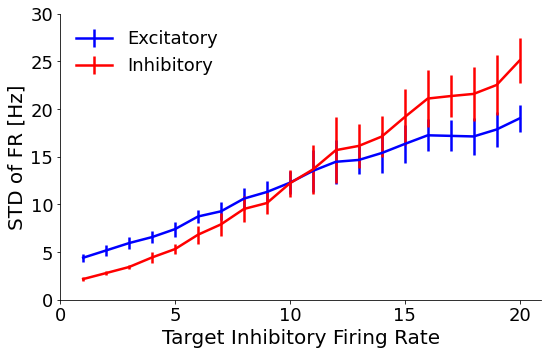

In [7]:
#Plot firing rates

fig, axs = plt.subplots(1,1,figsize=(7.7*1.12, 4.7*1.12))

fr_range=np.arange(1,21,1)
#STD instead of Variance
i_stats_bla = vary_i_stats.copy()
i_stats_bla[1,:,:] = np.sqrt(vary_i_stats[1,:,:])
i_stats_bla[3,:,:] = np.sqrt(vary_i_stats[3,:,:])


axs.errorbar(fr_range, np.mean(i_stats_bla, axis=1)[1, :], 
                                 yerr=np.std(i_stats_bla, axis=1)[1, :], label="Excitatory", c="b", lw=2.5)
axs.errorbar(fr_range, np.mean(i_stats_bla, axis=1)[3, :], 
                             yerr=np.std(i_stats_bla, axis=1)[3, :], label="Inhibitory", c="r", lw=2.5)
axs.set_xticks(np.arange(0,21,5))

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in axs.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)

axs.set_xlabel("Target Inhibitory Firing Rate", fontsize=20)
axs.set_ylabel("STD of FR [Hz]", fontsize=20)
axs.set_yticks([0,5,10,15,20,25,30])

axs.legend(fontsize=18, frameon=False)

sns.despine()

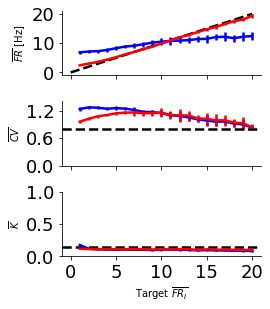

In [8]:
#Other stats
fig, axes = plt.subplots(3,1, figsize=(3.5, 4), sharex=True)

plt.tight_layout( w_pad=1.7, h_pad=1.6)
plt.rcParams['axes.labelsize'] = 20

stat_idx = [(0,2), (4,5), (6,7)]
y_labels = ["$\overline{FR}$ [Hz]", "$\overline{CV}$", "$\overline{K}$"]

for i in range(3):
    
    axs = axes[i]

    axs.errorbar(fr_range, np.mean(i_stats_bla, axis=1)[stat_idx[i][0], :], 
                                     yerr=np.std(i_stats_bla, axis=1)[stat_idx[i][0], :], label="excitatory", c="b", lw=2.5)
    axs.errorbar(fr_range, np.mean(i_stats_bla, axis=1)[stat_idx[i][1], :], 
                                 yerr=np.std(i_stats_bla, axis=1)[stat_idx[i][1], :], label="inhibitory", c="r", lw=2.5)
    axs.set_xticks(np.arange(0,21,5))

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    axs.set_ylabel(y_labels[i])

axes[0].plot(np.arange(0,21,1), np.arange(0,21,1), "k--", lw=2.5)
axes[0].set_yticks(np.arange(0,21,10))

axes[1].set_ylim([0,1.4])
axes[1].axhline(0.8, c="k", linestyle="--", lw=2.5)
axes[1].set_yticks(np.arange(0,1.4,0.6))

axes[2].set_ylim([0,1])
axes[2].axhline(0.15, c="k", linestyle="--", lw=2.5)
axes[2].set_yticks(np.arange(0,1.1,0.5))
axes[2].set_xticks(np.arange(0,21,5))
axes[2].set_xlabel("Target $\overline{FR_I}$")

sns.despine()

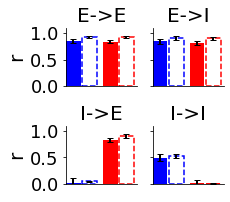

In [9]:
#Correlations for low target firing rate -> STD(FR_I) < STD(FR_E)
target_fr_idx = 1

ex_cor = np.mean(vary_i_ex_cors, axis=2)[:,:,target_fr_idx]
in_cor = np.mean(vary_i_in_cors, axis=2)[:,:,target_fr_idx]
ex_cor_std = np.std(vary_i_ex_cors, axis=2)[:,:,target_fr_idx]
in_cor_std = np.std(vary_i_in_cors, axis=2)[:,:,target_fr_idx]

mean_ana_r_e = np.mean(vary_i_ana_r_e, axis=1)[:, target_fr_idx]
mean_ana_r_i = np.mean(vary_i_ana_r_i, axis=1)[:, target_fr_idx]
std_ana_r_e = np.std(vary_i_ana_r_e, axis=1)[:, target_fr_idx]
std_ana_r_i = np.std(vary_i_ana_r_i, axis=1)[:, target_fr_idx]


fig, cor_plots = plt.subplots(2,2,figsize=(11.69/3*0.75, (16.54/4.5)*0.75), sharex=True, sharey=True)

plt.tight_layout( w_pad=0.0, h_pad=3)
plt.rcParams['axes.labelsize'] = 20


#cor_plots params
gap=0.2
a_gap=0.05
width = [0.5, 0.5]
a_width=[0.5,0.5]
error_kw = {"lw":2}
capsize=3
align="edge"
ylim=[0,1.1]
yticks = np.arange(0,1.1, 0.5)
fc = (0,0,0,0)
ec = ["b", "r"]
ls="dashed"
lw=1.5
position_0 = 0
position_1 = position_0+width[0]+a_gap+a_width[0]+gap
positions = [position_0, position_1]
a_positions = [position_0+width[0]+a_gap, position_1+width[1]+a_gap]
xlim = [position_0, a_positions[1]+a_width[1]+0.1]

cor_plots[0,0].bar(positions,[ex_cor[0][1], in_cor[0][1]], 
              yerr=[ex_cor_std[0][1], in_cor_std[0][1]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,0].bar(a_positions, [mean_ana_r_e[0], mean_ana_r_i[0]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[0], std_ana_r_i[0]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,0].set_ylim(ylim)
cor_plots[0,0].set_xlim(xlim)
cor_plots[0,0].set_yticks(yticks)
cor_plots[0,0].set_title("E->E", fontsize=20)

cor_plots[0,1].bar(positions,[ex_cor[1][2], in_cor[1][2]], 
              yerr=[ex_cor_std[1][2], in_cor_std[1][2]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,1].bar(a_positions, [mean_ana_r_e[1], mean_ana_r_i[1]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[1], std_ana_r_i[1]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,1].set_ylim(ylim)
cor_plots[0,1].set_xlim(xlim)
cor_plots[0,1].set_title("E->I", fontsize=20)

cor_plots[1,0].bar(positions,[ex_cor[2][3], in_cor[2][3]], 
              yerr=[ex_cor_std[2][3], in_cor_std[2][3]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,0].bar(a_positions, [mean_ana_r_e[2], mean_ana_r_i[2]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[2], std_ana_r_i[2]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,0].set_ylim(ylim)
cor_plots[1,0].set_xlim(xlim)
cor_plots[1,0].set_title("I->E", fontsize=20)

cor_plots[1,1].bar(positions,[ex_cor[3][4], in_cor[3][4]], 
              yerr=[ex_cor_std[3][4], in_cor_std[3][4]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,1].bar(a_positions, [mean_ana_r_e[3], mean_ana_r_i[3]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[3], std_ana_r_i[3]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,1].set_ylim(ylim)
cor_plots[1,1].set_xlim(xlim)
cor_plots[1,1].set_title("I->I", fontsize=20)

for tick in cor_plots[0,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
for tick in cor_plots[1,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
cor_plots[0,0].set_ylabel("r", fontsize=20)
cor_plots[1,0].set_ylabel("r", fontsize=20)

cor_plots[0,0].set_xticks([])

sns.despine()

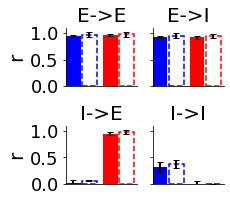

In [10]:
#Correlations for medium target firing rate -> STD(FR_I) = STD(FR_E)

target_fr_idx = 9

ex_cor = np.mean(vary_i_ex_cors, axis=2)[:,:,target_fr_idx]
in_cor = np.mean(vary_i_in_cors, axis=2)[:,:,target_fr_idx]
ex_cor_std = np.std(vary_i_ex_cors, axis=2)[:,:,target_fr_idx]
in_cor_std = np.std(vary_i_in_cors, axis=2)[:,:,target_fr_idx]

mean_ana_r_e = np.mean(vary_i_ana_r_e, axis=1)[:, target_fr_idx]
mean_ana_r_i = np.mean(vary_i_ana_r_i, axis=1)[:, target_fr_idx]
std_ana_r_e = np.std(vary_i_ana_r_e, axis=1)[:, target_fr_idx]
std_ana_r_i = np.std(vary_i_ana_r_i, axis=1)[:, target_fr_idx]

#fig, cor_plots = plt.subplots(2,2,figsize=(11.69/3.5*0.75, 16.54/4.5*0.75), sharex=True, sharey=True)
fig, cor_plots = plt.subplots(2,2,figsize=(11.69/3*0.75, 16.54/4.5*0.75), sharex=True, sharey=True)

plt.tight_layout( w_pad=0.0, h_pad=3)
plt.rcParams['axes.labelsize'] = 20


#cor_plots params
gap=0.2
a_gap=0.05
width = [0.5, 0.5]
a_width=[0.5,0.5]
error_kw = {"lw":2}
capsize=3
align="edge"
ylim=[0,1.1]
yticks = np.arange(0,1.1, 0.5)
fc = (0,0,0,0)
ec = ["b", "r"]
ls="dashed"
lw=1.5
position_0 = 0
position_1 = position_0+width[0]+a_gap+a_width[0]+gap
positions = [position_0, position_1]
a_positions = [position_0+width[0]+a_gap, position_1+width[1]+a_gap]
xlim = [position_0, a_positions[1]+a_width[1]+0.1]

cor_plots[0,0].bar(positions,[ex_cor[0][1], in_cor[0][1]], 
              yerr=[ex_cor_std[0][1], in_cor_std[0][1]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,0].bar(a_positions, [mean_ana_r_e[0], mean_ana_r_i[0]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[0], std_ana_r_i[0]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,0].set_ylim(ylim)
cor_plots[0,0].set_xlim(xlim)
cor_plots[0,0].set_yticks(yticks)
cor_plots[0,0].set_title("E->E", fontsize=20)

cor_plots[0,1].bar(positions,[ex_cor[1][2], in_cor[1][2]], 
              yerr=[ex_cor_std[1][2], in_cor_std[1][2]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,1].bar(a_positions, [mean_ana_r_e[1], mean_ana_r_i[1]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[1], std_ana_r_i[1]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,1].set_ylim(ylim)
cor_plots[0,1].set_xlim(xlim)
cor_plots[0,1].set_title("E->I", fontsize=20)

cor_plots[1,0].bar(positions,[ex_cor[2][3], in_cor[2][3]], 
              yerr=[ex_cor_std[2][3], in_cor_std[2][3]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,0].bar(a_positions, [mean_ana_r_e[2], mean_ana_r_i[2]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[2], std_ana_r_i[2]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,0].set_ylim(ylim)
cor_plots[1,0].set_xlim(xlim)
cor_plots[1,0].set_title("I->E", fontsize=20)

cor_plots[1,1].bar(positions,[ex_cor[3][4], in_cor[3][4]], 
              yerr=[ex_cor_std[3][4], in_cor_std[3][4]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,1].bar(a_positions, [mean_ana_r_e[3], mean_ana_r_i[3]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[3], std_ana_r_i[3]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,1].set_ylim(ylim)
cor_plots[1,1].set_xlim(xlim)
cor_plots[1,1].set_title("I->I", fontsize=20)

for tick in cor_plots[0,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
for tick in cor_plots[1,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
cor_plots[0,0].set_ylabel("r", fontsize=20)
cor_plots[1,0].set_ylabel("r", fontsize=20)
cor_plots[0,0].set_xticks([])


sns.despine()

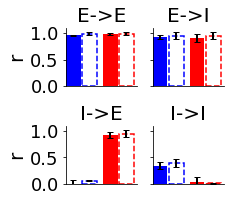

In [11]:
#Correlations for high target firing rate -> STD(FR_I) > STD(FR_E)

target_ei_idx = -2

ex_cor = np.mean(vary_i_ex_cors, axis=2)[:,:,target_ei_idx]
in_cor = np.mean(vary_i_in_cors, axis=2)[:,:,target_ei_idx]
ex_cor_std = np.std(vary_i_ex_cors, axis=2)[:,:,target_ei_idx]
in_cor_std = np.std(vary_i_in_cors, axis=2)[:,:,target_ei_idx]

mean_ana_r_e = np.mean(vary_i_ana_r_e, axis=1)[:, target_ei_idx]
mean_ana_r_i = np.mean(vary_i_ana_r_i, axis=1)[:, target_ei_idx]
std_ana_r_e = np.std(vary_i_ana_r_e, axis=1)[:, target_ei_idx]
std_ana_r_i = np.std(vary_i_ana_r_i, axis=1)[:, target_ei_idx]


fig, cor_plots = plt.subplots(2,2,figsize=(11.69/3*0.75, 16.54/4.5*0.75), sharex=True, sharey=True)

plt.tight_layout( w_pad=0.0, h_pad=3)
plt.rcParams['axes.labelsize'] = 20


#cor_plots params
gap=0.2
a_gap=0.05
width = [0.5, 0.5]
a_width=[0.5,0.5]
error_kw = {"lw":2}
capsize=3
align="edge"
ylim=[0,1.1]
yticks = np.arange(0,1.1, 0.5)
fc = (0,0,0,0)
ec = ["b", "r"]
ls="dashed"
lw=1.5
position_0 = 0
position_1 = position_0+width[0]+a_gap+a_width[0]+gap
positions = [position_0, position_1]
a_positions = [position_0+width[0]+a_gap, position_1+width[1]+a_gap]
xlim = [position_0, a_positions[1]+a_width[1]+0.1]

cor_plots[0,0].bar(positions,[ex_cor[0][1], in_cor[0][1]], 
              yerr=[ex_cor_std[0][1], in_cor_std[0][1]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,0].bar(a_positions, [mean_ana_r_e[0], mean_ana_r_i[0]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[0], std_ana_r_i[0]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,0].set_ylim(ylim)
cor_plots[0,0].set_xlim(xlim)
cor_plots[0,0].set_yticks(yticks)
cor_plots[0,0].set_title("E->E", fontsize=20)

cor_plots[0,1].bar(positions,[ex_cor[1][2], in_cor[1][2]], 
              yerr=[ex_cor_std[1][2], in_cor_std[1][2]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[0,1].bar(a_positions, [mean_ana_r_e[1], mean_ana_r_i[1]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[1], std_ana_r_i[1]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[0,1].set_ylim(ylim)
cor_plots[0,1].set_xlim(xlim)
cor_plots[0,1].set_title("E->I", fontsize=20)

cor_plots[1,0].bar(positions,[ex_cor[2][3], in_cor[2][3]], 
              yerr=[ex_cor_std[2][3], in_cor_std[2][3]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,0].bar(a_positions, [mean_ana_r_e[2], mean_ana_r_i[2]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[2], std_ana_r_i[2]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,0].set_ylim(ylim)
cor_plots[1,0].set_xlim(xlim)
cor_plots[1,0].set_title("I->E", fontsize=20)

cor_plots[1,1].bar(positions,[ex_cor[3][4], in_cor[3][4]], 
              yerr=[ex_cor_std[3][4], in_cor_std[3][4]], error_kw = error_kw, capsize=capsize,
              width  = width, color = ['b', 'r'], align = align)
cor_plots[1,1].bar(a_positions, [mean_ana_r_e[3], mean_ana_r_i[3]], facecolor=fc, edgecolor=ec, ls=ls, lw=lw,
                   yerr=[std_ana_r_e[3], std_ana_r_i[3]], error_kw = error_kw, capsize=capsize,
                  width=a_width, align=align)
cor_plots[1,1].set_ylim(ylim)
cor_plots[1,1].set_xlim(xlim)
cor_plots[1,1].set_title("I->I", fontsize=20)

for tick in cor_plots[0,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
for tick in cor_plots[1,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
cor_plots[0,0].set_ylabel("r", fontsize=20)
cor_plots[1,0].set_ylabel("r", fontsize=20)
cor_plots[0,0].set_xticks([])


sns.despine()

In [ ]:
#Evaluate quality of posterior
n_runs=10

med_error_map = np.zeros((len(fr_range), len(obs)))

for i, fr in tqdm(enumerate(fr_range)):
    obs_to_compare = copy(obs)
    obs_to_compare[2] = fr
    
    me = median_distance(obs_to_compare, posterior02, n_runs=10, strategy="map")
    
    #errors in stats for each run
    error_array = np.zeros((n_runs, len(obs)))
    
    for ii in range(n_runs):
        #Get best estimate of parameters from sbi
        temp_params = posterior.map(x=obs_to_compare, num_iter=100, 
                                       learning_rate=0.01, num_init_samples=1000, num_to_optimize=100, 
                                       save_best_every=50, show_progress_bars=False)
        #Results with best param estimate
        temp_res = calc_stats([simulator(temp_params)])
        #STD instead of Var
        temp_res[1] = np.sqrt(temp_res[1])
        temp_res[3] = np.sqrt(temp_res[3])
        #Same for target obs
        obs_to_compare_std = copy(obs_to_compare)
        obs_to_compare_std[1] = np.sqrt(obs_to_compare_std[1])
        obs_to_compare_std[3] = np.sqrt(obs_to_compare_std[3])
        
        error_array[ii,:] = np.abs(np.array(obs_to_compare_std)-np.array(new_stats))
    
    #Add to median error array
    med_error_map[i,:] = np.nanmedian(error_array, axis=0)

In [12]:
#Of course I have some prepared
all_mes = np.zeros((len(np.arange(1,21,1)),8))
all_mes_std = np.zeros((len(np.arange(1,21,1)),8))

all_mes[0:5,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_21-09-1_6-21.npy")
all_mes_std[0:5,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_std_21-09-1_6-21.npy")

all_mes[5:10,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_21-09-6_11-21.npy")
all_mes_std[5:10,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_std_21-09-6_11-21.npy")

for i in range(5):
    all_mes[10+i*2:10+(i+1)*2,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_21-09-%s_%s-21.npy" %(10+i*2+1, 10+(i+1)*2+1))
    all_mes_std[10+i*2:10+(i+1)*2,:] = np.load("/home/npatzlaff/Documents/Inhibition_defines/results/med_error_map_std_21-09-%s_%s-21.npy" %(10+i*2+1, 10+(i+1)*2+1))

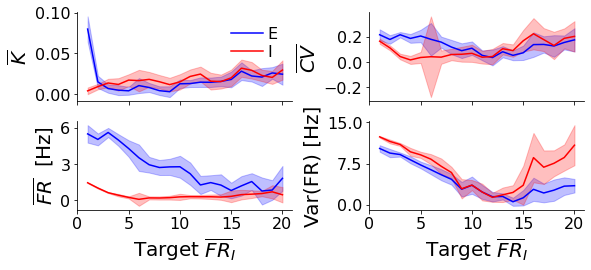

In [13]:
#Plots of errors for all stats

scaling=1/1.24

fig, axes = plt.subplots(2,2, figsize=((11.69/1.2)*scaling,16.54/4*scaling), sharex=True)
plt.tight_layout(w_pad=4, h_pad=1)
plt.rcParams['axes.labelsize'] = 18

stat_pairs = [(6,7), (0,2), (4,5), (1,3)]
stat_labels = ["$\overline{K}$", "$\overline{FR}$  [Hz]", "$\overline{CV}$", "Var(FR) [Hz]"]

alph = 0.25

for i in range(4):
    idx = stat_pairs[i]
    axes[i%2][int(i>1)].plot(fr_range, all_mes[:,idx[0]], color="b", label="E")
    axes[i%2][int(i>1)].fill_between(fr_range, all_mes[:,idx[0]]+all_mes_std[:,idx[0]], all_mes[:,idx[0]]-all_mes_std[:,idx[0]],
                                    color="b", alpha=alph)
    axes[i%2][int(i>1)].plot(fr_range, all_mes[:,idx[1]], color="r", label="I")
    axes[i%2][int(i>1)].fill_between(fr_range, all_mes[:,idx[1]]+all_mes_std[:,idx[1]], all_mes[:,idx[1]]-all_mes_std[:,idx[1]],
                                    color="r", alpha=alph)
    axes[i%2][int(i>1)].set_ylabel(stat_labels[i])
    
    for tick in axes[i%2][int(i>1)].xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in axes[i%2][int(i>1)].yaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    
axes[0,0].legend(fontsize=16, frameon=False, handletextpad=0.3, labelspacing=0.2)
axes[0,0].set_xticks([0,5,10,15,20])
axes[1,0].set_xlabel("Target $\overline{FR}_I$")
axes[1,1].set_xlabel("Target $\overline{FR}_I$")

axes[0,0].set_yticks([0,0.05,0.1])
axes[0,1].set_yticks([-0.2, 0, 0.2])
axes[1,0].set_yticks([0,3,6])
axes[1,1].set_yticks([0, 7.5, 15])

sns.despine()